In [ ]:
"""
# clone a NASLib fork that supports python 3.11
!git clone -b automl-conf-24 --single-branch git@github.com:gabikadlecova/NASLib.git

# install NASLib
%cd NASLib
%pip install -e .
# %pip install ConfigSpace==0.6 --quiet
%cd ..
"""

# download dataset apis and NAS-Bench-Suite Zero data
"""
%cd /content/NASLib
!source scripts/bash_scripts/download_benchmarks.sh nb201 cifar10
# !source scripts/bash_scripts/download_benchmarks.sh nb201 cifar100
# !source scripts/bash_scripts/download_benchmarks.sh nb201 ImageNet16-120
# !source scripts/bash_scripts/download_benchmarks.sh nb301 cifar10
# !source scripts/zc/bash_scripts/download_nbs_zero.sh nb101
!source scripts/zc/bash_scripts/download_nbs_zero.sh nb201
# !source scripts/zc/bash_scripts/download_nbs_zero.sh nb301
"""

In [ ]:
"""
!git clone git@github.com:gabikadlecova/GRAF.git
%cd GRAF
%pip install -e .
%cd ..

%pip install shap
"""

In [4]:
# ------ Setup ------ #
benchmark = 'nb201'
dataset = 'cifar10'

feature_cfg = '../graf_nas/configs/nb201.json'

naslib_path = '../../zero_cost/NASLib'

# 0. Introduction to the GRAF library

GRAF is an extensible library that enables enables computation of zero-cost proxies, neural graph features, and
performance prediction.

Right now, GRAF is a wrapper around NASLib object and zero-cost proxy functions, but is extensible to user defined search spaces and zero-cost proxies. GRAF focuses on easy analysis and application of ZCP and graph features. NASLib supports many features that GRAF does not - e.g. input encoding for GNN predictors.

In this section, we will learn how
- search spaces are represented in GRAF
- to convert networks to their architectural graph representation
- to get PyTorch modules that correspond to the networks
- compute zero-cost proxies and neural graph features

## Search spaces

Every network is represented by a **string hash** that corresponds to the hash in NASLib (obtained via naslib_object.get_has()). Usually, it is a list of operation indices, but it depends on the specific search space.

GRAF enables you to extract the graph representation of the network, and convert it to networkx:

In [5]:
from graf_nas.search_space import NB201

net = '(2, 0, 0, 2, 0, 2)'  # a network with 3 sequential 3x3 conv-bn-relu, and skip-connections between them

# unified representation of architectures from a search space
network = NB201(net, cache_model=True)
print("Network: ", network.net)

# the network can be converted to a graph
graph = network.to_graph()
print("Edges: ", graph.edges)
print("Ops: ", graph.ops)
print("Networkx graph: ", graph.to_graph())


Network:  (2, 0, 0, 2, 0, 2)
Edges:  {(1, 2): 2, (1, 3): 0, (1, 4): 0, (2, 3): 2, (2, 4): 0, (3, 4): 2}
Ops:  {0: 'skip_connect', 1: 'none', 2: 'nor_conv_3x3', 3: 'nor_conv_1x1', 4: 'avg_pool_3x3'}
Networkx graph:  DiGraph with 4 nodes and 6 edges


The network can be convered to a PyTorch module. Implementation for included search spaces -- initialize a NASLib search space object and parse it to a `torch.nn.Module`.

In [2]:
import torch

# you can convert the network to a parsed NASLib object
model = network.get_model()
print(model)

# it is a PyTorch model
print("Is it torch.nn.Module: ", isinstance(model, torch.nn.Module))

model(torch.randn(1, 3, 32, 32))  # you can directly pass data to the model

NasBench201SearchSpace named 'makrograph' with 20 nodes and 19 edges
Is it torch.nn.Module:  True


tensor([[-0.0026, -0.0248,  0.1126,  0.1976, -0.1839, -0.0226,  0.1574,  0.2459,
          0.2547, -0.0132]], grad_fn=<AddmmBackward0>)

You can iterate over all networks in a search space (you need to download the NASLib dataset api - we've done that at the start of the notebook)

In [ ]:
from graf_nas.search_space import searchspace_classes, dataset_api_maps
from naslib.utils import get_dataset_api

# you can also get the NB201 class by indexing the searchspace_classes dictionary
net_cls = searchspace_classes[benchmark]

# the class itself supports iterating over all architectures in the search space
dataset_api = get_dataset_api(search_space=dataset_api_maps[benchmark], dataset=dataset)
net_iterator = net_cls.get_arch_iterator(dataset_api)

next(iter(net_iterator)).net

'(0, 0, 0, 0, 0, 0)'

## Zero-cost proxies

GRAF supports evaluation of NASLib zero-cost proxies. The zero-cost proxies need a DataLoader -- you can load it with `get_zcp_dataloader` and referencing a config file in NASLib

In [5]:
# GRAF support easy computation of all zero-cost proxies in NAS-Bench-Suite Zero (and also extension with new ones)
import os
from graf_nas.features.zero_cost import get_zcp_predictor, get_zcp_dataloader, available_measures

print('Available NASLib zero-cost proxies: ', available_measures)

# You need to download the data loader for ZCP computation
dataloader = get_zcp_dataloader(dataset=dataset, zc_cfg=os.path.join(naslib_path, 'naslib/runners/zc/zc_config.yaml'), data=naslib_path)

# You can get a predictor for a specific zero-cost proxy
predictor = get_zcp_predictor('synflow', dataloader=dataloader)
print(predictor)

# using the PyTorch model from previous cells, compute the synflow score! (you might want to change to the GPU runtime)
print(predictor(model))

Available NASLib zero-cost proxies:  ['grad_norm', 'snip', 'grasp', 'fisher', 'jacov', 'plain', 'synflow_bn', 'synflow', 'epe_nas', 'zen', 'l2_norm', 'nwot']
Files already downloaded and verified
Files already downloaded and verified
synflow
111.84541218759227


## Neural Graph features

Neural Graph features (GRAF) are simple properties of the graph:
- operation counts
- min path lengthfrom the input to the output**
- maximum path length from the input to the output**
- input-output node degrees**

**restricted to an operation set (e.g. only counting [skip,conv3x3])

You can learn more about them in [a blogpost on GRAF](https://gabikadlecova.github.io/blog/2024/graf/)

Features for a given benchmark are described by a config file:

In [4]:
import json
import pprint

# represented by a config
with open(feature_cfg, 'r') as f:
    cfg = json.load(f)

# This config contains 4 features - operation counts, min path length, max path length, and node degrees
pprint.pprint(cfg, sort_dicts=False)

[{'name': 'op_count'},
 {'name': 'min_path_len',
  'allowed': ['skip_connect',
              'none',
              'nor_conv_3x3',
              'nor_conv_1x1',
              'avg_pool_3x3']},
 {'name': 'max_op_on_path',
  'allowed': ['skip_connect',
              'none',
              'nor_conv_3x3',
              'nor_conv_1x1',
              'avg_pool_3x3']},
 {'name': 'node_degree',
  'allowed': ['skip_connect',
              'none',
              'nor_conv_3x3',
              'nor_conv_1x1',
              'avg_pool_3x3']}]


Load callable feature objects using the config file:

In [5]:
from graf_nas.features.config import load_from_config

# the features from the config are loaded as a list of objects
features = load_from_config(cfg, benchmark)
print(features[:2])
print()

# these represent graf features limited to a subset of the operation set
print([str(f) for f in features[:10:2]])

[<graf_nas.features.base.Feature object at 0x7f9db5634310>, <graf_nas.features.base.ConstrainedFeature object at 0x7f9c9c3eb150>]

['op_count', 'min_path_len_(none)', 'min_path_len_(nor_conv_1x1)', 'min_path_len_(skip_connect,none)', 'min_path_len_(skip_connect,nor_conv_1x1)']


Example feature - minimum path length when using only skip connections

In [6]:
some_feat = features[1]

print(f"Computing {some_feat} for the following network:")
print({k: graph.ops[v] for k, v in graph.edges.items()})
print()

print("Result: ", some_feat(graph))  # you can compute the features for a network graph

Computing min_path_len_(skip_connect) for the following network:
{(1, 2): 'nor_conv_3x3', (1, 3): 'skip_connect', (1, 4): 'skip_connect', (2, 3): 'nor_conv_3x3', (2, 4): 'skip_connect', (3, 4): 'nor_conv_3x3'}

Result:  1


# 1. Zero-cost proxy biases

The authors of NAS-Bench-Suite Zero highlighed some of the zero-cost proxy biases, such as the convolution to pooling ratio. [1] We will analyze the bias with the operation count -- number of convolutions, while looking at scatter plots of network scores and accuracies.

[1] Krishnakumar, A. et al. (2022). NAS-Bench-Suite-Zero: Accelerating Research on Zero Cost Proxies. In Advances in Neural Information Processing Systems (pp. 28037–28051). Curran Associates, Inc..

We first load the NB-Suite-Zero json data of zero-cost proxy evaluations (downloaded at the top of the notebook):

In [9]:
import json
import os
from graf_nas.features.zero_cost import parse_scores

# load NAS-Bench-Suite Zero data for NB201
with open(os.path.join(naslib_path, 'naslib/data/zc_nasbench201.json'), 'r') as f:
    zc_data = json.load(f)

# convert it to DataFrame for easier analysis of the whole search space
zc_dataframe = parse_scores(zc_data, dataset)

Since NB201 contains networks with unreachable operations (due to zero operations) that skew the zero-cost proxy analysis, we will remove them. 

In [29]:
from graf_nas.search_space.reduntant import remove_zero_branches

# the NB201 benchmark contains networks with unreachable operations - let's remove them
new_index = []
zero_op = 1

for net in zc_dataframe.index:
    graph = NB201(net).to_graph()
    
    # skip if networks contains unreachable operations - this function zeroed them out
    new_graph = remove_zero_branches(graph, zero_op=zero_op)
    if new_graph.edges != graph.edges:
        continue

    new_index.append(net)

print('Before removal: ', len(zc_dataframe))
zc_dataframe = zc_dataframe.loc[new_index].copy()
print('After removal: ', len(zc_dataframe))

Before removal:  15625
After removal:  9445


In [34]:
import pprint
pprint.pprint(zc_dataframe.head())

                    val_accs      epe_nas    fisher      flops   grad_norm       grasp      jacov     l2_norm        nwot    params     plain        snip    synflow         zen
net                                                                                                                                                                             
(4, 0, 3, 1, 4, 3)     84.99  1283.299108  0.036440  19.248832   10.883215    0.244735 -88.289871  130.200516  754.684333  0.129306  0.033875   22.923178  44.484811   63.387894
(2, 4, 0, 0, 3, 2)     90.52  1712.860614  0.023383  85.235392   12.691692    2.205327 -65.193310  180.487396  785.622961  0.587386  0.079539   26.610859  85.295247  119.493332
(0, 0, 2, 1, 2, 3)     88.32  1892.558689  0.091167  83.945152   24.872454   12.207823 -65.285305  180.934311  788.917398  0.587386  0.077502   51.889561  60.212156   92.669968
(4, 1, 3, 3, 3, 3)     87.35  1379.897450  0.161322  26.683072   41.271332   23.266205 -78.714333  231.918152  803.

Let's plot NASWOT (denoted `nwot`) against validation accuracy

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# ylims per proxy (each has different score ranges and outliers)
ylims = {'nwot': (550, 850)}

def plt_ylim(prox):
    if prox not in ylims:
        return
    plt.ylim(ylims[prox][0], ylims[prox][1])

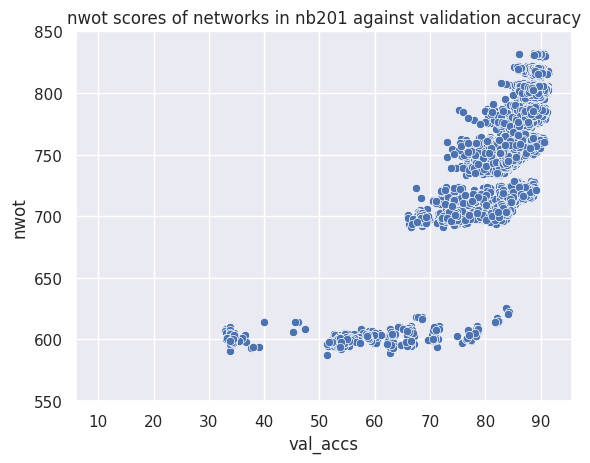

In [32]:
proxy = 'nwot'

sns.scatterplot(data=zc_dataframe, x='val_accs', y=proxy)
plt_ylim(proxy)
plt.title(f"{proxy} scores of networks in {benchmark} against validation accuracy")
plt.show()

You can see some clusters forming. We could look at networks from the bottom cluster:

In [25]:
op_map = NB201.get_op_map()
print("The meaning of numbers: ", op_map)

nwot_cluster = zc_dataframe[zc_dataframe[proxy] < 650]
nwot_cluster.index[:6].to_list()

The meaning of numbers:  {'skip_connect': 0, 'none': 1, 'nor_conv_3x3': 2, 'nor_conv_1x1': 3, 'avg_pool_3x3': 4}


['(4, 0, 0, 4, 4, 4)',
 '(4, 0, 4, 0, 0, 0)',
 '(4, 0, 1, 0, 1, 4)',
 '(4, 4, 1, 4, 4, 4)',
 '(4, 4, 0, 1, 4, 4)',
 '(0, 4, 4, 4, 0, 0)']

Seems like there are no convolutions in the network... Let's compute the number of convs via GRAF and mark the clusters:

In [26]:
import pandas as pd

n_convs = []
op_count_func = features[0]  # run the cells in section 0 for this to work

for net in zc_dataframe.index:
    op_counts = op_count_func(NB201(net).to_graph())
    
    conv_1_id, conv_3_id = op_map['nor_conv_1x1'], op_map['nor_conv_3x3']
    n_convs.append(op_counts[conv_1_id] + op_counts[conv_3_id])

zc_dataframe['n_convs'] = n_convs
zc_dataframe['n_convs'] = pd.Categorical(zc_dataframe['n_convs'])

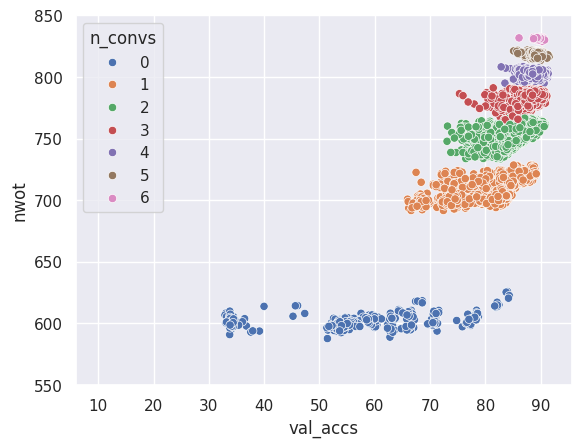

In [27]:
sns.scatterplot(data=zc_dataframe, x='val_accs', y=proxy, hue='n_convs')
#plt.xlim(70, 91)
plt_ylim(proxy)
plt.title(f"{proxy} scores of networks in {benchmark} against validation accuracy")
plt.show()

Uh-oh, seems like `nwot` has a high dependency on the number of convolutions! If you analyze the clusters further (exercise), you see that the scores in the clusters also depend on the number of `conv3x3`

In [30]:
# ----- optional exercise -----
# Analyze one of the clusters (e.g. the one with 3 convolutions)

# a) filter DataFrame to get only nets with 3 convs
# b) create a column - n_convs_3x3 (use op_counts again)
# c) plot the clusters with hue set to n_cobvs_3x3

# **** your code ****
pass

Disclaimer: this happens mostly in NB201, the effect in NB101 is lower, and DARTS does not seem to be directly affected.

Nevertheless, the proxies have the highest score on NB201, and for some of them, these biases are one of the reasons. In other words, both `val_accs` and `nwot` correlate with the number of convolutions.

### Exercise - plot other proxies / analyze other benchmarks

Choose one of the proxies in the dataframe and analyze its relationship to operation count (or perhaps other features).

You can also set `benchmark = 'nb101'` and `feature_cfg = graf_nas/configs/nb101.json` and analyze a different search space. The code for downloading `zc_nasbench101.json` is at the top of the notebook (it was commented out to save time).

In [ ]:
from graf_nas.search_space import DARTS, NB101

# **** your code ****
pass

# 2. Performance prediction via GRAF

In this section, we will explore using the ZCP and features as network encoding for performance prediction.
The setup will be:

- train networks - 100 nets from NB201
- encoding - ZCP + features
- target - CIFAR10
- predictor - Random Forest

## GRAF - easy computation of ZCP and features

GRAF enables computing all available ZCP and features for a given network in one function call. We can either compute them, or use cached data that satisfies:

1. index are net hashes
2. columns are ZCP/feature names

For ZCP, the data we loaded from NB-Suite-Zero before is compatible

In [7]:
from graf_nas.graf import GRAF
zcp_names = ['epe_nas', 'fisher', 'flops', 'grad_norm', 'grasp', 'jacov', 'l2_norm', 'nwot', 'params', 'plain', 'snip', 'synflow', 'zen']

# GRAF unifies computation of features and zero-cost proxies
graf_model = GRAF(benchmark,
                  features=features,  # either a list of features, or a path to the config file
                  zcp_predictors=zcp_names,  # a list of zero-cost proxy names or predictor objects
                  cached_data=zc_dataframe,  # you can use data from NB Suite Zero to avoid ZCP computation
                  cache_features=True)  # cache computed features from GRAF

Example how features are computed:

In [13]:
feats = graf_model.compute_features(network)  # compute features for a network

i = 0
for k, v in feats.items():
    print(f"{k}: {v}")
    i += 1
    if i > 7:
        print('...')
        break

op_count_0: 3
op_count_1: 0
op_count_2: 3
op_count_3: 0
op_count_4: 0
min_path_len_(skip_connect): 1
min_path_len_(none): 6
min_path_len_(nor_conv_3x3): 3
...


Example how ZCP are computed/extracted from the cache:

In [14]:
graf_model.compute_zcp_scores(network)

{'epe_nas': 1657.737740511819,
 'fisher': 0.009487888775765896,
 'flops': 115.402432,
 'grad_norm': 9.60776424407959,
 'grasp': 0.19346094131469727,
 'jacov': -65.20240181876179,
 'l2_norm': 180.5452880859375,
 'nwot': 785.0347715480094,
 'params': 0.802426,
 'plain': 0.1098535805940628,
 'snip': 18.618627548217773,
 'synflow': 111.92830625120547,
 'zen': 139.31690979003906}

GRAF supports creating a dataset for the performance prediction (in the form of a DataFrame) - the rows are networks, the columns are ZCP and features.

In [8]:
from graf_nas.graf import create_dataset

# graf_nas contains a helper function for creating a tabular dataset:
use_onehot = False
use_zcp = True
use_features = True
target = 'val_accs'

# you need a net iterator - we will use the index from NB Suite Zero
net_iterator = (NB201(n) for n in zc_dataframe.index.to_list())

# alternatively, use the iterators with NASLib dataset api
# net_iterator = NB201.get_arch_iterator(dataset_api)

feature_dataset, y = create_dataset(graf_model, net_iterator,
                                    target_df=zc_dataframe, target_name=target,  # dataframe with the target column (optional)
                                    use_features=use_features, use_zcp=use_zcp, use_onehot=use_onehot,  # which encodings to use
                                    drop_unreachables=benchmark == 'nb201')  # search space with zero ops

16it [00:00, 70.37it/s]

15625it [02:42, 96.33it/s] 


In [10]:
# full set of features for the networks
pprint.pprint(feature_dataset.head())

                    op_count_0  op_count_1  op_count_2  op_count_3  op_count_4  min_path_len_(skip_connect)  min_path_len_(none)  min_path_len_(nor_conv_3x3)  min_path_len_(nor_conv_1x1)  min_path_len_(avg_pool_3x3)  min_path_len_(skip_connect,none)  min_path_len_(skip_connect,nor_conv_3x3)  min_path_len_(skip_connect,nor_conv_1x1)  min_path_len_(skip_connect,avg_pool_3x3)  min_path_len_(none,nor_conv_3x3)  min_path_len_(none,nor_conv_1x1)  min_path_len_(none,avg_pool_3x3)  min_path_len_(nor_conv_3x3,nor_conv_1x1)  min_path_len_(nor_conv_3x3,avg_pool_3x3)  min_path_len_(nor_conv_1x1,avg_pool_3x3)  min_path_len_(skip_connect,none,nor_conv_3x3)  min_path_len_(skip_connect,none,nor_conv_1x1)  min_path_len_(skip_connect,none,avg_pool_3x3)  min_path_len_(skip_connect,nor_conv_3x3,nor_conv_1x1)  min_path_len_(skip_connect,nor_conv_3x3,avg_pool_3x3)  min_path_len_(skip_connect,nor_conv_1x1,avg_pool_3x3)  min_path_len_(none,nor_conv_3x3,nor_conv_1x1)  \
(4, 0, 3, 1, 4, 3)           1          

### Exercise: analyze the features

- a) plot some of them just like we did with nwot before
- b) compute the correlation with the target, get the max values

In [116]:
# **** your code ****
pass

## Train a performance predictor

Now we train and evaluate the performance predictor. The train set are the 100 sampled networks, the test set are all remaining networks in the search space. We compute the correlation and other metrics:

In [11]:
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import spearmanr, kendalltau
from sklearn.metrics import r2_score, mean_squared_error

def get_train_test_splits(feature_dataset, y, train_size, seed):
    train_X, test_X, train_y, test_y = train_test_split(feature_dataset, y, train_size=train_size, random_state=seed)
    return {'train_X': train_X, 'train_y': train_y, 'test_X': test_X, 'test_y': test_y}


def eval_model(model, data_splits):
    start = time.time()
    model.fit(data_splits['train_X'], data_splits['train_y'])
    fit_time = time.time() - start

    preds = model.predict(data_splits['test_X'])
    true = data_splits['test_y']

    res = {
        'fit_time': fit_time,
        'r2': r2_score(true, preds),
        'mse': mean_squared_error(true, preds),
        'corr': spearmanr(preds, true)[0],
        'tau': kendalltau(preds, true)[0]
    }

    return res

In [13]:
seed = 42
n_evals = 50
train_size = 100

# we use the Random Forest, because it's fast to fit. In practice, you would use a tuned XGBoost or a tabular AutoML system
rf = RandomForestRegressor()

data_splits = get_train_test_splits(feature_dataset, y, train_size, seed)
res = eval_model(rf, data_splits)

print(res)

{'fit_time': 0.4751884937286377, 'r2': 0.6042614113474791, 'mse': 18.67546095691381, 'corr': 0.9140756208774302, 'tau': 0.7443707437594393}


We should evaluate the model multiple times:

In [17]:
# ideally, evaluate the model multiple times and report the mean/std ...
import pandas as pd


results = []
for i in range(n_evals):
    data_seed = seed + i
    data_splits = get_train_test_splits(feature_dataset, y, train_size, data_seed)
    
    rf = RandomForestRegressor()

    res = eval_model(rf, data_splits)
    res['seed'] = data_seed
    results.append(res)

res_df = pd.DataFrame(results)
print(res_df.mean())

fit_time     0.375859
r2           0.743025
mse         12.092550
corr         0.926532
tau          0.767057
seed        66.500000
dtype: float64


# 3. Interpretability via SHAP

One of the advantages of the GRAF encoding is the performance prediction interpretability. For that, we use the SHAP library.

We compute mean shapley values for every ZCP/feature.

In [18]:
import numpy as np
import shap

# function for computing the shapley values
def shap_importances(model, test_X):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(test_X)
    shap_values = np.abs(shap_values).mean(axis=0)
    return shap_values

In [20]:
shapvals = shap_importances(rf, data_splits['test_X'])

In [24]:
# shapley values match the number of data columns
feature_names = data_splits['test_X'].columns
len(shapvals), len(feature_names)

(204, 204)

In [25]:
importances = pd.DataFrame({'name': feature_names, 'shap': shapvals})
importances.head()

,name,shap
0,op_count_0,0.002082
1,op_count_1,0.008196
2,op_count_2,0.014873
3,op_count_3,0.001956
4,op_count_4,0.006066


Then, we look at the most important features - with the highest absolute shapley value.

We see that for this prediction task, some zero-cost proxies are important, and then node degrees of none and average pooling - i.e. is the output preceded either by zero-op, or avg pooling? Compared to a convolution 3x3 or 1x1.

In [30]:
# get the most important features according to shap

importances.sort_values('shap', ascending=False)[:10]

,name,shap
191,epe_nas,1.915670
196,jacov,0.594716
198,nwot,0.491787
194,grad_norm,0.149341
114,"node_degree_(none,avg_pool_3x3)_avg_out",0.130905
197,l2_norm,0.123606
113,"node_degree_(none,avg_pool_3x3)_avg_in",0.111720
137,"node_degree_(skip_connect,none,avg_pool_3x3)_a...",0.111578
141,"node_degree_(skip_connect,nor_conv_3x3,nor_con...",0.111196
203,zen,0.102282


### Exercise - look at importances when using only the features
Using `create_dataset`, create a new input dataset. Then, train a new predictor and analyze the importances. You can also experiment with different predictors.

Alternatively, compare the `cifar10` importances with the `cifar100` and `ImageNet16-120` datasets (requires loading a different dataset from `zc_nasbench201.json`)

In [31]:
# **** your code ****
pass

### Exercise - look at how important features change when doing performance prediction for another dataset
- Replace the dataset at the top, then, do the performance prediction and interpretability again
- Compare how the most important features/ZCP change

In [ ]:
# **** your code ****
pass

# 4. Extending the GRAF library

## Your own zero-cost proxy!

In this section, you learn how to implement your own zero-cost proxy.

You can look at zero-cost proxy code in NASLib for inspiration: https://github.com/automl/NASLib/tree/Develop/naslib/predictors/utils/pruners/measures

Zero-cost proxies in NASLib are mostly adapted from https://github.com/SamsungLabs/zero-cost-nas/tree/main/foresight/pruners/measures but there are also some extra ones

In [100]:
def is_conv3x3(module):
    return isinstance(module, torch.nn.Conv2d) and str(module.kernel_size) == '(3, 3)'

# get all the convs3x3
[name for name, module in model.named_modules() if is_conv3x3(module)][:5]

['makrograph-edge(1,2).seq.0',
 'makrograph-edge(2,3).cell-edge(1,2).op.1',
 'makrograph-edge(2,3).cell-edge(2,3).op.1',
 'makrograph-edge(2,3).cell-edge(3,4).op.1',
 'makrograph-edge(3,4).cell-edge(1,2).op.1']

Here, we implement a proxy that computes the numer of params only for conv3x3.

In [2]:
# proxy function
def compute_conv3x3_params(net):
    def is_conv3x3(module):
        return isinstance(module, torch.nn.Conv2d) and str(module.kernel_size) == '(3, 3)'

    conv_params = 0
    for _, module in net.named_modules():
        if not is_conv3x3(module):
            continue
        conv_params += sum([p.flatten().shape[0] for p in module.parameters()])

    return conv_params / 1e6  # params in NB-Suite-Zero are actually megaparams

In [11]:
from graf_nas.features.zero_cost import ZeroCostFunc, zero_cost_proxies

scorer = ZeroCostFunc('conv3x3_params', compute_conv3x3_params)
print(f"{scorer.name}: ", scorer(network.get_model()), " | params: ", zc_dataframe.loc[network.net]['params'])

conv3x3_params:  0.795312  | params:  0.802426


In [15]:
from graf_nas.features.zero_cost import get_zcp_predictor
from functools import partial

# you can also register the function to available zero-cost proxies
zero_cost_proxies['conv3x3_params'] = partial(ZeroCostFunc, 'conv3x3_params', compute_conv3x3_params)

# then, you get the scorer in GRAF via a name
get_zcp_predictor('conv3x3_params')(network.get_model())

0.795312

## New feature in GRAF

Here you implement a new feature - the ratio of conv3x3 to conv 1x1

In [114]:
from graf_nas.search_space.base import NetGraph
from graf_nas.features.base import Feature

def conv_3x3_to_1x1_ratio(net: NetGraph) -> float:
    n_3x3 = 0
    n_1x1 = 0

    for edge_val in net.edges.values():
        if net.ops[edge_val] == 'nor_conv_3x3':
            n_3x3 += 1
        elif net.ops[edge_val] == 'nor_conv_1x1':
            n_1x1 += 1

    return n_3x3 / n_1x1 if n_1x1 > 0 else 10  # "infinity" :-)

ratio_feat = Feature('conv3x3_to_conv1x1', conv_3x3_to_1x1_ratio)

n = '(2, 3, 2, 3, 2, 3)'
print(ratio_feat(NB201(n).to_graph()))

n = '(2, 3, 2, 3, 2, 0)'
print(ratio_feat(NB201(n).to_graph()))

1.0
1.5


In [ ]:
from graf_nas.features.nasbench201 import feature_func_dict

# add a function to the `feature_func_dict` - then, you can include it in the config file
feature_func_dict['conv3x3_to_conv1x1'] = conv_3x3_to_1x1_ratio

### Exercise idea
- count the number of conv3x3 bridges in the graph (i.e. after removing the edge, no other conv3x3 reaches the output)

In [107]:
# **** your code here ****
pass

## Add a new search space
Do you want to use GRAF with your own search space? This is what you need to do:

- implement a class with NetBase as the base class
- look at e.g. `graf_nas.features.nasbench201` and create a similar `feature_func` dict
- add it to `graf_nas/features/__init__.py`, also add the search space class to `graf_nas/search_spaces/__init__.py`
- create a config similar to ``graf_nas/configs/nb201.json`

A more detailed example may follow in the future - stay tuned :)

In [ ]:
from graf_nas.search_space.base import NetBase

class MyOwnSearchSpace(NetBase):
    def __init__(self, net: str, cache_model: bool = False):
        super().__init__(net, cache_model=cache_model)

    def to_graph(self) -> NetGraph:
        """
        Converts the network to its graph representation. If you want ops on edges, look
        at graf_nas.search_space.NetGraph - it is compatible with the NB201 feature functions.
        """
        # TODO NetGraph accepts op map and edges
        #  - op map maps ids to op names: e.g {'conv3x3': 0, 'skip': 1}
        #  - edge_map maps edges to ids: e.g. {(1, 2): 0, (2, 3): 1, (1, 3): 0}
        raise NotImplementedError()

    def to_onehot(self) -> np.ndarray:
        # TODO convert the network to onehot encoding
        raise NotImplementedError()

    def create_model(self) -> torch.nn.Module:
        # TODO convert the network to a torch module - e.g. by interpreting self.to_graph()
        raise NotImplementedError()

    @staticmethod
    def get_op_map():
        # TODO return mapping from operation names to ids
        raise NotImplementedError()

    @staticmethod
    def get_arch_iterator():
        # TODO return all network hashes
        raise NotImplementedError()